### 1 - Definição do problema

Doenças cardiovasculares são a causa número 1 de mortes num contexto global. Representando 31% do total de mortes anuais
mundialmente.

Individuos que sofrem de doença cardiovascular ou estão em risco de sofrer (devido à presença de um ou mais fatores,
considerados de risco, como, hipertensão, diabetes, hiperlipidemia ou devido a outra doença), beneficiam de uma prematura
deteção e gestão para minimizar o risco de um agravamento de sintomas ou até manisfestação da doença.

Assim, é importante analisar dados clinicos de atuais pacientes e individous já considerados de risco, de maneira a
poder-se melhorar a capacidade de deteção de indícios da manisfestação da doença, por forma de melhor evitá-la ou pelo
menos mitigar os seus efeitos.

### 2 - Aquisição dos dados
Os dados utilizados para este trabalho foram retirados do Kaggle em https://www.kaggle.com/fedesoriano/heart-failure-prediction
e representam um agregado de conjuntos de dados clínicos de pacientes das seguintes instituições:

* Cleveland: 303 observations
* Hungarian: 294 observations
* Switzerland: 123 observations
* Long Beach VA: 200 observations
* Stalog (Heart) Data Set: 270 observations

E fornecidos por:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Estes dados já tinham sido anteriormente ligeiramente preparados, isto, é, já tinha sido feito uma remoção prévia de
dados duplicados.


## 3 - Data Wrangling

Nesta etapa as seguintes tarefas vão ser realizadas:
- Importar o dataset e fazer a limpeza de valores NaN (vazios)
- Renomear algumas colunas para melhor compreensão dos dados
- Converter nomenclaturas/abreviações para melhor processamento de dados
- Criar uma nova coluna de faixas etárias para agrupar os diferentes individuos
- Criar novas colunas indicando se os niveis de colestrol, batimento cardiacos
são normais, acima ou abaixo da média

Importar as bibliotecas que vão ser utilizadas

In [370]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
sns.set()

Machine Learning algorithms

In [371]:
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix #for confusion matrix
from sklearn.preprocessing import LabelEncoder

Importar o dataset

In [372]:
df = pd.read_csv('../data/heart.csv', sep=",", encoding="utf-8")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [374]:
df.drop_duplicates()
df.shape

(918, 12)

The dataset doesn't contain any nulls by default or duplicated values.

Vamos renomear algumas colunas para tornar os dados mais perceptiveis.

In [375]:
df = df.rename(columns={'Sex': 'Gender', 'FastingBS': 'Diabetes', 'MaxHR': 'MaxHeartRate', 'Oldpeak': 'STDeviation',})

Now lets take a look at the non-metric columns

In [376]:
categorical = ["Gender", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for value in categorical:
    print(df[value].value_counts(normalize=True), "\n")

M    0.78976
F    0.21024
Name: Gender, dtype: float64 

ASY    0.540305
NAP    0.221133
ATA    0.188453
TA     0.050109
Name: ChestPainType, dtype: float64 

Normal    0.601307
LVH       0.204793
ST        0.193900
Name: RestingECG, dtype: float64 

N    0.595861
Y    0.404139
Name: ExerciseAngina, dtype: float64 

Flat    0.501089
Up      0.430283
Down    0.068627
Name: ST_Slope, dtype: float64 



### Variables transformations

Since the column values seem to be specific categories, they can be converted in
numerical values to facilitate processing

In [377]:
enc = LabelEncoder()

# Gender: M -> 1 | F -> 0
enc.fit(df['Gender'])
df['Gender'] = enc.transform(df['Gender'])

# ChestPainType: ASY -> 0 | ATA -> 1 | NAP -> 2 | TA -> 3
enc.fit(df['ChestPainType'])
df['ChestPainType'] = enc.transform(df['ChestPainType'])

# RestingECG: LVH -> 0 | Normal -> 1 | ST -> 2
enc.fit(df['RestingECG'])
df['RestingECG'] = enc.transform(df['RestingECG'])

# ExerciseAngina: N -> 0 | Y -> 1
enc.fit(df['ExerciseAngina'])
df['ExerciseAngina'] = enc.transform(df['ExerciseAngina'])

# ST_Slope: Down -> 0 | Flat -> 1 | Up -> 2
enc.fit(df['ST_Slope'])
df['ST_Slope'] = enc.transform(df['ST_Slope'])

df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


##### Faixas etárias

Vamos categorizar as idades dos individuos no dataset, agrupando-os por faixas etárias
para melhor analisar os resultados dos dados clínicos destes.

In [378]:
df_extra_info = df.copy()
bins = np.arange(20, 100, 15)

df['AgeClass'] = np.digitize(df['Age'], bins, right=True)

Função génerica classificadora de dados como sendo altos, baixos ou normais.

Assim vai ser criada uma coluna onde os niveis de cada panciente estão classificados entre 'low', 'normal' e 'high'.


In [379]:
def f(row,col_name, min_value, high_value):
    if row[col_name] < min_value:
        val = 'Low'
    elif min_value < row[col_name] <= high_value:
        val = 'Normal'
    else:
        val = 'High'
    return val

##### Niveis de colestrol

O nivel de colestrol total para um adulto normal varia entre 125 a 200 mg/dL.

In [380]:
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

##### Niveis pressão sanguinea em repouso

O nivel de pressão sanguinea para um adulto normal varia entre 90/60mmHg e 120/80mmHg. Sendo considerada elevada quando
ultrapassa os 140/90mmHg.

In [381]:
df['RestingBPClass'] = df.apply(lambda row: f(row,'RestingBP', 90, 140) , axis=1)

##### Niveis máximos de batimentos cardiacos

Segundo, https://www.drjohnm.org/2011/08/whats-a-normal-heart-rate/
os niveis de batimentos cardiacos podem variar muito, pois estes são influenciados por diferentes fatores, como fatores
genéticos, hormonais, idade, historico de saúde, etc.

Para simplificação foi considerado que para um adulto normal, irião ser assumidos como um niveís normaais entre os
60 e os 100 batimentos/minuto.

In [382]:
df['MaxHeartRateClass'] = df.apply(lambda row: f(row,'MaxHeartRate', 90, 140) , axis=1)

Data set final após Data Wrangling.

In [383]:
df

,Age,Gender,ChestPainType,RestingBP,Cholesterol,Diabetes,RestingECG,MaxHeartRate,ExerciseAngina,STDeviation,ST_Slope,HeartDisease,AgeClass,CholesterolClass,RestingBPClass,MaxHeartRateClass
0,40,1,1,140,289,0,1,172,0,0.0,2,0,2,High,Normal,High
1,49,0,2,160,180,0,1,156,0,1.0,1,1,2,Normal,High,High
2,37,1,1,130,283,0,2,98,0,0.0,2,0,2,High,Normal,Normal
3,48,0,0,138,214,0,1,108,1,1.5,1,1,2,High,Normal,Normal
4,54,1,2,150,195,0,1,122,0,0.0,2,0,3,Normal,High,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1,2,High,Normal,Normal
914,68,1,0,144,193,1,1,141,0,3.4,1,1,4,Normal,High,High
915,57,1,0,130,131,0,1,115,1,1.2,1,1,3,Normal,Normal,Normal
916,57,0,1,130,236,0,0,174,0,0.0,1,1,3,High,Normal,High


## 4 - EDA

O EDA vai estar divido em três secções:
- Compreensão dos dados clínicos
- Análise por tabelas de valores (value_counts entre outros)
- Remoção de outliers
- Análise por grupos de dados

### Compriender os dados

#### restingECG
O ECG deteta os sinais elétricos do coração, uma vez que cada contração do músculo cardíaco ou das válvulas cardíacas
emite um impulso, este exame mede o tempo e a força dos impulsos elétricos.

Este teste pode ser feito de duas maneiras, em repouso (resting) ou em esforço/stress e providencia informação sobre o
batimento cardiaco e ritmo, podendo demonstrar se existe aumento do coração devido a uma elevada pressão sanguinea.

Por esse motivo, é o exame indicado para o despiste de arritmias cardíacas ou para a deteção
precoce de indicadores de isquemia cardíaca.

De notar que um resultado “normal” neste exame, não é suficiente para excluir uma doença
cardiovascular.

Nestes dados aparece como
* Normal
* ST - tendo onda ST segmentation anormal (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* LVH (left ventricular hipertrophy)

A presença de ST segmentation num ECG, deve-se a uma quebra no fluxo da corrente no grandiente de zonas isquémicas e
não-isquémicas, que afeta o fase de plateau, isto é, do potencial de ação transmembrana ventricular e por conseguinte
causa o ST segment.


#### ST Slope
Segundo, https://www.ncbi.nlm.nih.gov/books/NBK459364/
ST Slope or ST Segmentation é uma importante componente de um ECG e é, a forma que este pode tomar
acima (ST elevation) ou abaixo (ST depression) da linha de referência. Para além disso é importante caracterizar a
forma da onda do ST segment, pois este pode ser classificado como horizontal (flat), upsloping, ou downsloping
(sendo os últimos dois rápidos ou lentos) que são os dados presentes nesta
coluna.

Implicações destes fatores:
* A presença de uma ST elevation é uma causa comum para a deteção de fatores como LVH
* Em geral uma isquemia cardíaca é representada por uma ST depression, enquanto que uma lesão cardiáca pode ser indicada
por uma ST elevation
* É preciso ter em conta que nem todas as ST elevations ou ST depression representam isquemia cardíaca ou condições
emergentes, contudo multiplas condições estão associadas a estes fatores.

#### STDeviation

Está relacionada com a ocorrência de uma ST depression, representando as mudanças das ondas T, onde tanto para homens
como para mulheres os valores de referência são de -0.05 mV em V e -0.1 mV em todas as restantes.

Segundo, https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/
para quantificar as variações dos ST segments, calcula-se a variação em milimetros até ao ponto J da onda do ECG.

Assim, assume-se que os valores desta coluna, são dados em milemetros (mm) e que como está associada aos valores da
ST depression, valores, negativos, referem-se a medições de uma ST elevation.


#### ExerciseAngina

Angina é a dor que pode ocorrer durante a prática de exercício fisíco, stress ou outras coisas semelhantes que façam o
o coração trabalhar em esforço.

É um sintóma comum para doença na artéria coronária que pode ser causada artérias coronárias bloqueadas por colestrol.


### Análise por tabelas de valores

In [384]:
df['Cholesterol'].value_counts(normalize=True)

0      0.187364
254    0.011983
223    0.010893
220    0.010893
230    0.009804
         ...   
392    0.001089
316    0.001089
153    0.001089
466    0.001089
131    0.001089
Name: Cholesterol, Length: 222, dtype: float64

Verifica-se que existem 172 pacientes com valor 0, o que em termos médicos não faria sentido registarem estes valores.

Uma vez que 172 pacientes representam 18% do dataset, a sua remoção poderia ter impactos negativos em futuras
análises. Assim ao invés de serem removidos optou-se por substituir estes valores pela mediana da coluna em questão.

In [385]:
df['Cholesterol'] = df['Cholesterol'].apply(lambda x: df['Cholesterol'].median() if x < 75 else x)
df['CholesterolClass'] = df.apply(lambda row: f(row,'Cholesterol', 125, 200) , axis=1)

#### Outliers

Metric features ['Age', 'RestingBP', 'Cholesterol', 'MaxHeartRate', 'STDeviation']


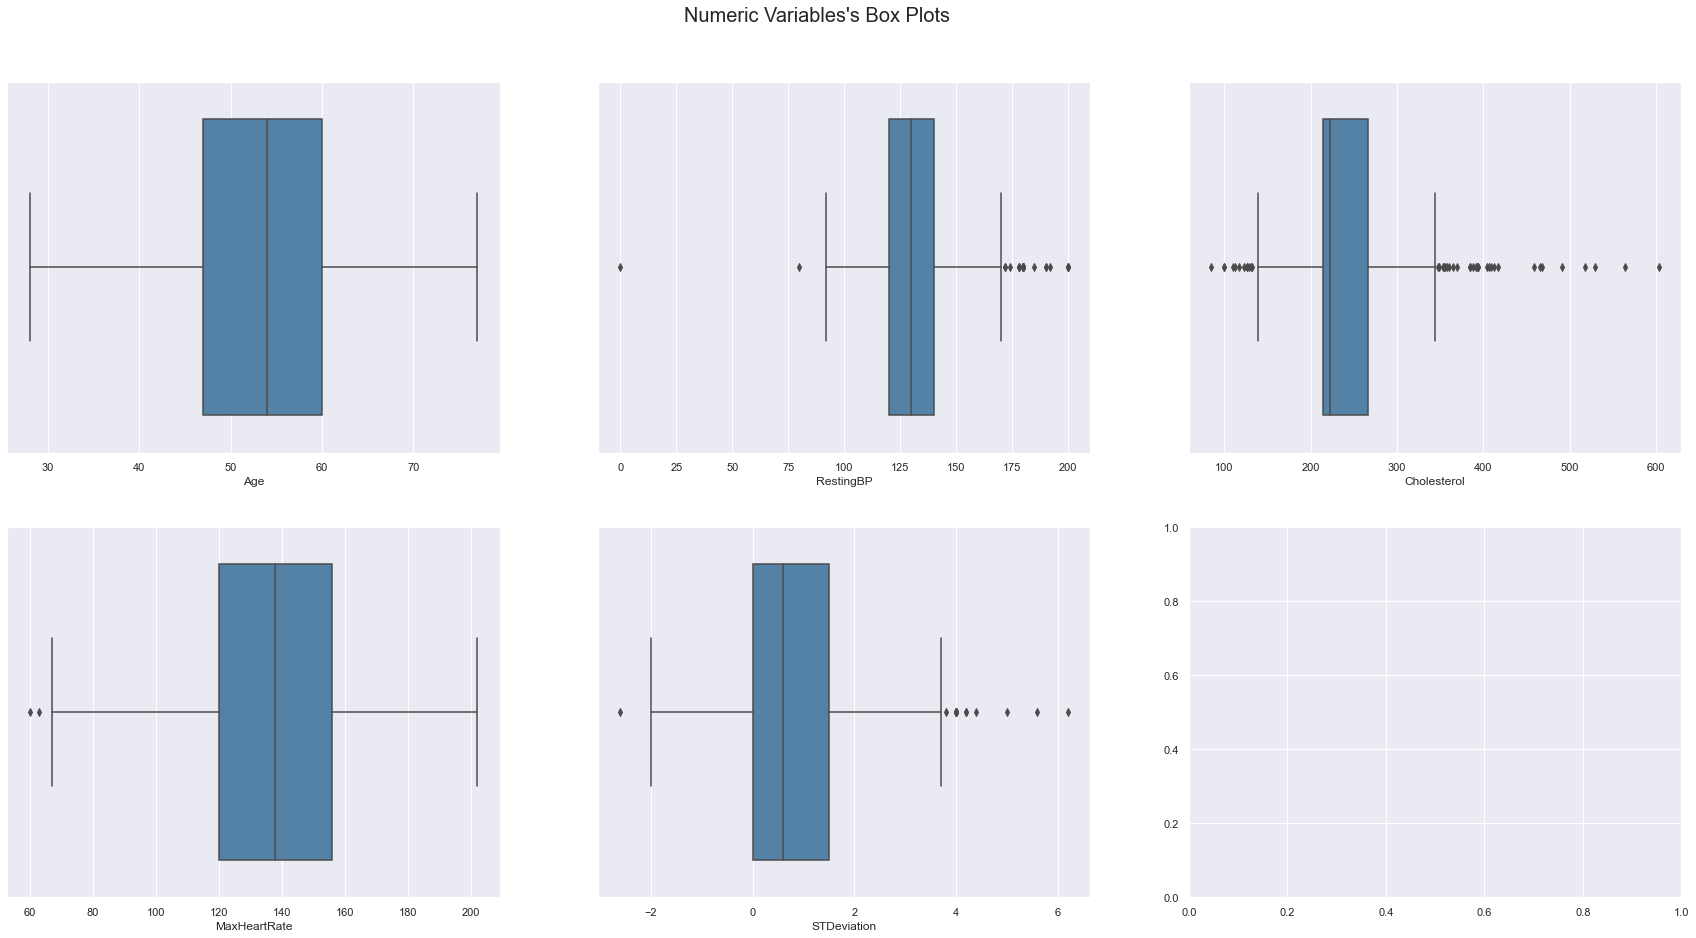

In [386]:
non_metric_features = ["Gender", "ChestPainType", "Diabetes", "RestingECG", "ExerciseAngina", "ST_Slope",
                       "HeartDisease", "AgeClass", "CholesterolClass", "RestingBPClass", "MaxHeartRateClass"]

metric_features = df.columns.drop(non_metric_features).to_list()
print("Metric features", metric_features)

sns.set()
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(30, 15))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax, color='steelblue')

title = "Numeric Variables's Box Plots"
plt.suptitle(title, y=0.95, fontsize=20)
plt.show()

#### Remoção dos outliers

In [387]:
outliers_filter = ( (df['RestingBP'] > 75) & (df['STDeviation'] >= 0))
df_no_outliers = df[outliers_filter].copy()
df_no_outliers.shape

(904, 16)

In [388]:
print('Percentage of data kept after removing outliers:', np.round(df_no_outliers.shape[0] / df.shape[0], 4)*100, '%')
print('Percentage of data removed:', np.round((1-(df_no_outliers.shape[0] / df.shape[0]))*100, 4), '%')

df = df_no_outliers

Percentage of data kept after removing outliers: 98.47 %
Percentage of data removed: 1.5251 %


Verifica-se a existência de alguns outliers nas variaveis numéricas, como, por exemplo, nos dados da pressão sanguinea
e niveis de colestrol, contudo, a existência destes “outliars” pode estar correlacionada com a presença
de doença do coração, isto é, pode ser um fator que contribui para esta se manifestar.

Assim, apenas outliears que representavam dados irrealistas de acordo com o significado clinico da variável,
foram removidos.

### Análise por grupos de dados

#### Distribuição por género

<AxesSubplot:ylabel='Gender'>

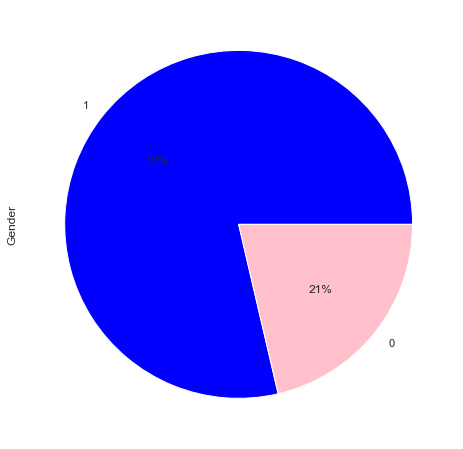

In [389]:
df['Gender'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["blue", "pink"])

Verifica-se que aproximadamente 4 em 5 individous neste conjunto de dados são homems

#### Análise em função da existência de doenças de cardiovasculares

<AxesSubplot:ylabel='HeartDisease'>

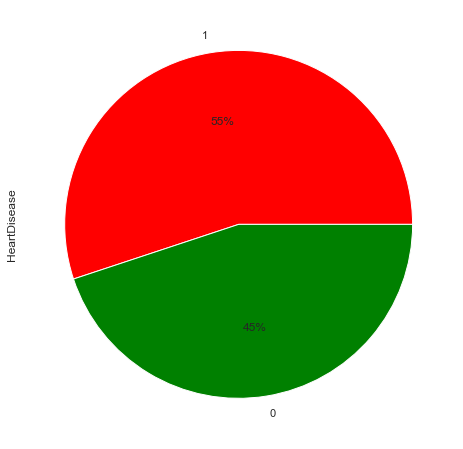

In [390]:
df['HeartDisease'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "green"])

O dataset aparenta ser quase balanceado neste aspeto, uma vez que existem quase tantos casos com
doença de coração como sem.

##### Distribuição por idades

<AxesSubplot:>

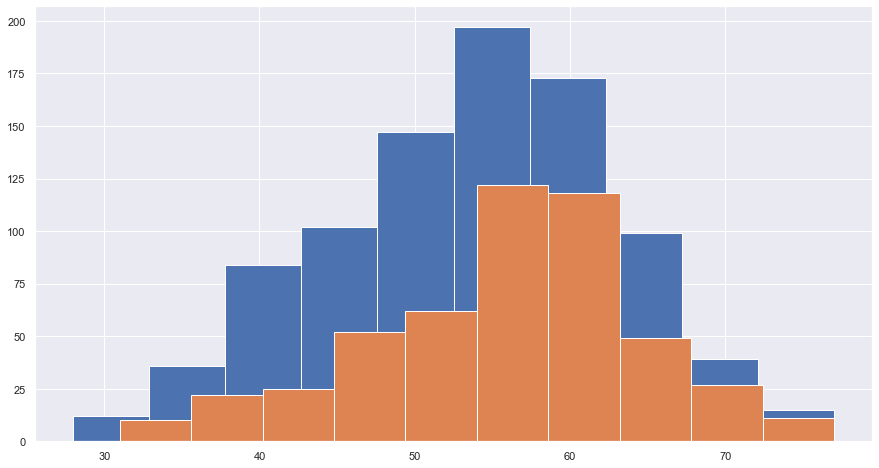

In [391]:
df_heart_disease = df[df.HeartDisease.apply(lambda x: x == 1)]
df['Age'].hist()
df_heart_disease['Age'].hist()

Ao analisar a distribuição de idades constata-se que a maior parte dos individuos tem entre 50 e 65 anos.

Ao comparar-se a distribuição das idades com as idades em que individuos sofrem de
doenças do coração verifica-se que esta é mais comum na faixa etária entre os 55 e 65 anos

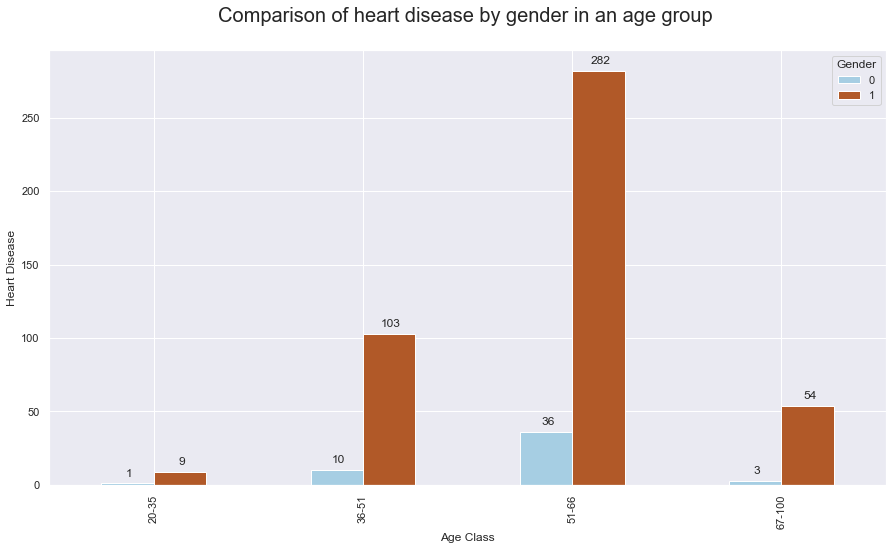

In [392]:
counts = df_heart_disease.groupby(['AgeClass', 'Gender']).Age.count().unstack()

ax = counts.plot(kind='bar',stacked = False, colormap = 'Paired')

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

ax.set_xticklabels(['20-35','36-51','51-66','67-100'])
plt.xlabel ('Age Class')
plt.ylabel ('Heart Disease')
plt.title('Comparison of heart disease by gender in an age group \n',fontsize=20)
plt.show()

Filtrando os dados por individuos apenas com doença de coração, e tendo em conta a desproporção do género neste dataset
verifica-se que homems entre os 51 e os 66 anos sofrem ligeiramente mais com esta doença.

##### Niveis de colestrol

In [393]:
df['CholesterolClass'].value_counts(normalize=True)

High      0.835177
Normal    0.157080
Low       0.007743
Name: CholesterolClass, dtype: float64

(array([[755.,   0.,   0.,   0.,   0., 142.,   0.,   0.,   0.,   7.],
        [439.,   0.,   0.,   0.,   0.,  54.,   0.,   0.,   0.,   5.]]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 2 BarContainer objects>)

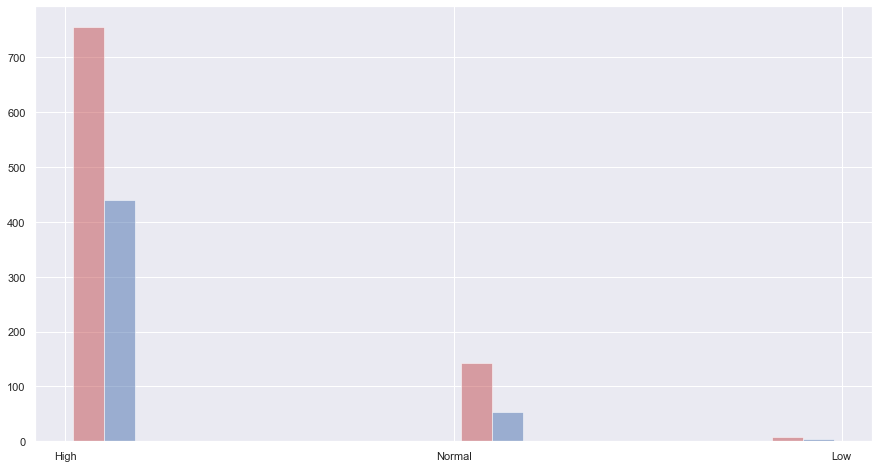

In [394]:
plt.hist([df['CholesterolClass'], df_heart_disease['CholesterolClass']], color=['r','b'], alpha=0.5)

In [395]:
# Percentage of cholesterol_type in individuals with heart disease
df_heart_disease['CholesterolClass'].value_counts() / df['CholesterolClass'].value_counts()

High      0.581457
Normal    0.380282
Low       0.714286
Name: CholesterolClass, dtype: float64

Comparando a ocorrência de doença de coração com os niveis de colestrol, é possivel verificar
que 50% dos individuos com colestrol alto sofrem da mesma e que 88%
dos que apresentam niveis baixos também.

Esta analise demonstra também que em individuos com niveis normais de colestrol, a presença da doença
é de 38%, contudo, é importante notar, que 83% dos individuos neste dataset apresenta niveis
elevados de colestrol, muito em parte devido a ter-se assumido para os 18% dos dados que tinham os niveis colestrol em
falta, que seria atribuido o valor da mediana (289).

#### Pressão Sanguinea

In [396]:
print('Total\n',df['RestingBPClass'].value_counts(normalize=True), '\n')
print('Heart Disease\n',df_heart_disease['RestingBPClass'].value_counts())

Total
 Normal    0.755531
High      0.243363
Low       0.001106
Name: RestingBPClass, dtype: float64 

Heart Disease
 Normal    348
High      150
Name: RestingBPClass, dtype: int64


(array([[683.,   0.,   0.,   0.,   0., 220.,   0.,   0.,   0.,   1.],
        [348.,   0.,   0.,   0.,   0., 150.,   0.,   0.,   0.,   0.]]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 2 BarContainer objects>)

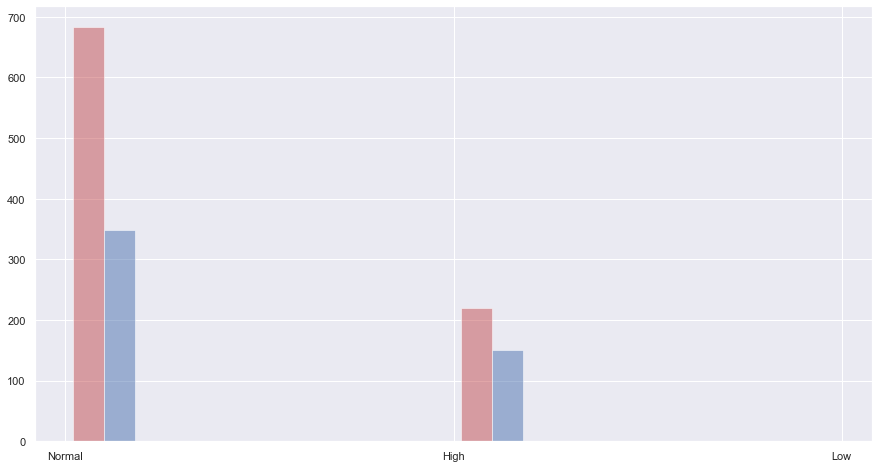

In [397]:
plt.hist([df['RestingBPClass'], df_heart_disease['RestingBPClass']], color=['r','b'], alpha=0.5)

In [398]:
# Percentage of RestingBPClass in individuals with heart disease
df_heart_disease['RestingBPClass'].value_counts() / df['RestingBPClass'].value_counts()

High      0.681818
Low            NaN
Normal    0.509517
Name: RestingBPClass, dtype: float64

Comparando a ocorrência de doença de coração com os niveis de pressão sanguinea, é possivel verificar
que 68% dos individuos com pressão alta sofrem da mesma. Devido a este dataset não conter nenhuns casos de pressão
baixa, não é possivel tirar conclusões sobre esta.

Esta analise demonstra também que em individuos com niveis normais de pressão sanguinea, a presença da doença
é de 51%, contudo, é importante notar, que estes são dados sobre pressão sanguinea em repouso, que para um quadro
clinico, podem tirar grande disparidade da pressão sanguinea quando um individuo está em esforço.

##### Nivel de açucar no sangue em jejum

É um indicador obtido através da colheita de sangue em jejum, feito normalmente, durante a noite.
Um nível inferior a 100 mg/dl é considerado normal, entre 100 e 125 mg/dl é indicador de pré-diabetes e acima disso
o paciente tem diabetes (geralmente fazem-se 2 testes diferentes para confirmar os resultos).

Neste dataset, estes valores são distinguidos entre ter diabetes (1) e não ter diabetes (0), ou seja, pacientes marcados
com “1” tinham valores acima de 120 mg/dl.

In [399]:
# 0 -> no diabetes | 1 -> has diabetes
df['Diabetes'].value_counts(normalize=True)

0    0.772124
1    0.227876
Name: Diabetes, dtype: float64

(array([[698.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 206.],
        [336.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 162.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

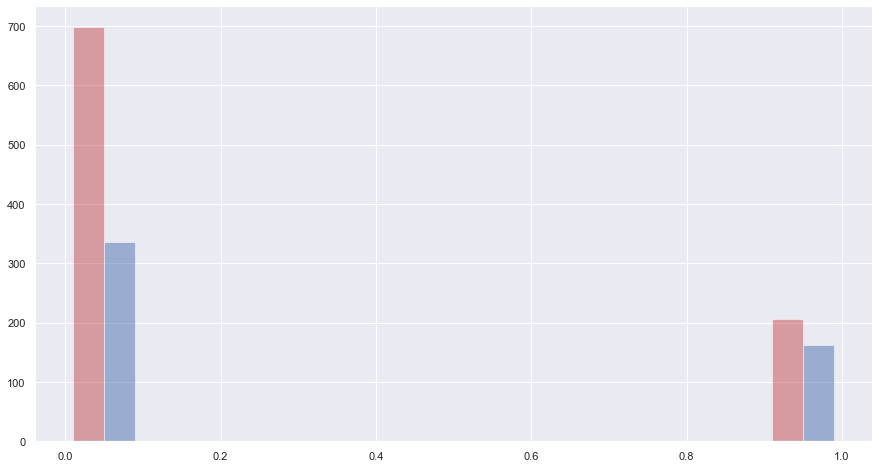

In [400]:
plt.hist([df['Diabetes'], df_heart_disease['Diabetes']], color=['r','b'], alpha=0.5)

In [401]:
# Percentage of cholesterol_type in individuals with heart disease
df_heart_disease['Diabetes'].value_counts() / df['Diabetes'].value_counts()

0    0.481375
1    0.786408
Name: Diabetes, dtype: float64

Tem como métrica os dados

##### Tipos de dores no peito

In [402]:
# TODO relacionar ChestPainTypes com ExerciseAngina


#### ST Elevation

ST elevation appears to be more pronounced in young and middle-aged males than in females.

#### Correlações

<AxesSubplot:>

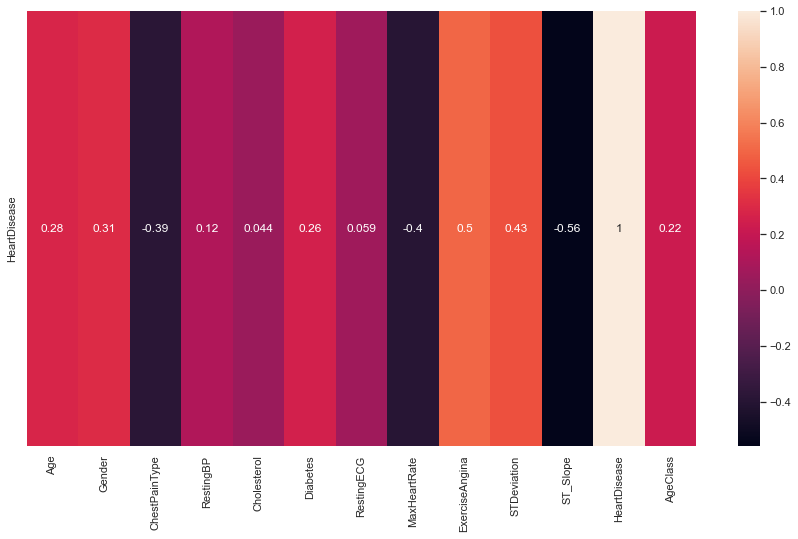

In [403]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=df.corr().loc[['HeartDisease']], annot=True)

Escrever conclusão sobre o gráfico

<AxesSubplot:>

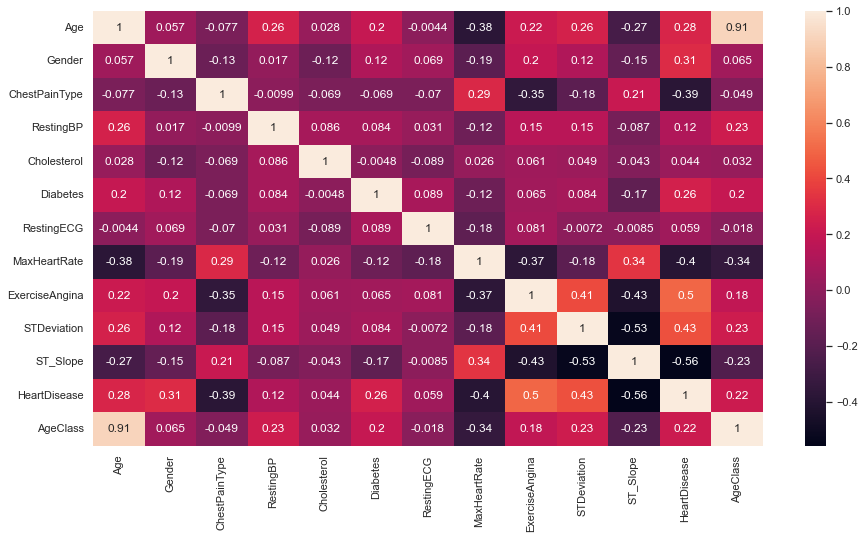

In [404]:
sns.heatmap(data=df.corr(), annot=True)

Parece que os dados não se correlacionam diretamente, apenas destacando-se uma ligeira correlação entre doenças de
coração e Angina durante exercício

## Machine learning

### Model Pipeline

In [405]:
def randomForestPredictPipeline(features, targets):
    normalized_f = normalizeFeatures(features)
    x_train, x_test, y_train, y_test = train_test_split(normalized_f,targets,test_size=0.8, random_state = 42)
    rfc = RandomForestClassifier()
    rfc.fit(x_train,y_train)
    return rfc.score(x_test,y_test)

#### Normalização dos dados

In [406]:
def normalizeFeatures(features):
    scaler = StandardScaler()
    scaler.fit(features)
    return scaler.transform(features)

### Improved Feature Selection

Agora que temos uma baseline definida, vamos tentar melhorar o modelo, fazendo uma melhor feature selection

#### Filter by variance

Variaveis com pouca variedade geralmente não são boas para modelos efeitos de previsão, por isso
podem ser descartadas.

In [407]:
df_features = df.drop("HeartDisease",axis = 1)
df_features.var()

/var/folders/7r/g2lhjv3x7bb_lgcnhj7_q9hr0000gn/T/ipykernel_1025/530169073.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_features.var()


Age                 88.955983
Gender               0.168101
ChestPainType        0.909040
RestingBP          322.289173
Cholesterol       2947.761439
Diabetes             0.176143
RestingECG           0.398431
MaxHeartRate       641.976891
ExerciseAngina       0.241633
STDeviation          1.096924
ST_Slope             0.366546
AgeClass             0.453649
dtype: float64

#### Filter by correlation

In [408]:
abs(df.corr()['HeartDisease'])

Age               0.280911
Gender            0.305665
ChestPainType     0.386767
RestingBP         0.123750
Cholesterol       0.043630
Diabetes          0.257235
RestingECG        0.058915
MaxHeartRate      0.398938
ExerciseAngina    0.499182
STDeviation       0.428793
ST_Slope          0.557514
HeartDisease      1.000000
AgeClass          0.223929
Name: HeartDisease, dtype: float64

Este tipo da análise permite ver que apesar de a coluna 'ST_Slope' ter baixa variância, é a que apresenta maior
correlação com a existência de doença do coração.

De modo a analisar a precisão de acordo com o nivel de correlação escolhido, corre-se o mesmo modelo para diferentes
niveis de correlação.

In [416]:
corrs = [0.1, 0.2, 0.3, 0.4, 0.5]

for corr in corrs:
    high_corr_cols = abs(df.corr()['HeartDisease'][abs(df.corr()['HeartDisease'])>corr].drop('HeartDisease')).index.tolist()
    df_features = df[high_corr_cols]
    targets = df["HeartDisease"]
    inputs = df_features
    print('min correlation:',corr,'- precision:',randomForestPredictPipeline(inputs, targets),'\n')


min correlation: 0.1 - precision: 0.850828729281768 

min correlation: 0.2 - precision: 0.8494475138121547 

min correlation: 0.3 - precision: 0.8397790055248618 

min correlation: 0.4 - precision: 0.8024861878453039 

min correlation: 0.5 - precision: 0.8093922651933702 



Model result presentation ideas

In [413]:
#y_hat = rfc.predict(x_test)
#final_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_hat})
#final_result

Precisão

In [414]:
#print(f"Acuraccy: {round(rfc.score(x_test,y_test),2)*100}%")